# Twitch data analysis

This script allows to obtain 4 dataset needed to create the graph model:

1. **Dataset Streamer**
- `ID_streamer`
- `streamer`
- `minutes_live`
- `viewer_mean`
- `viewer_peak`
- `spect_mean`
- `spect_tot`
- `social_link(?)`

2. **Dataset Games**
- `ID_game`
- `game_name`
- ...

3. **Dataset Streamer-Games**
- `ID_streamer`
- `ID_game`
- `minutes`

4. **Dataset Streamer-Streamer**
- `ID_streamer_i`
- `ID_streamer_j`
- `overlap_percentage`

## PreProcessing

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import json
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

### Setup parameters

In [2]:
interval = 5                      # Interval between observations (fixed)
freq = 3                          # Sample frequency (1=5min, 2=10min, 3=15min ecc.)
min_stream_time = 4               # Minimum live time parameter
min_watch_time = 2                # Minimum threshold of time as a spectator (min_watch_time <= min_stream_time)
min_viewer_mean = 10              # Minimum number of mean viewers
min_spect_mean = min_viewer_mean  # Minimum number of mean spectator
min_overlap_percentage = 10       # Minimum overlap percentage between 2 streamers
min_game_time = 2                 # Minimum number of minutes streamed for each category/game

print(f'Minimum live time threshold:\t\t\t {interval * freq * min_stream_time} min')
print(f'Minimum threshold of time as a spectator:\t {interval * freq * min_watch_time} min')

Minimum live time threshold:			 60 min
Minimum threshold of time as a spectator:	 30 min


### Import data

Example `'pasquale890': {'spect': ['anytow'], 'game_name': 'FIFA 22', 'viewer_count': 0}`


In [3]:
relpath1 = '..\DataCollection\Twitch_stream_spect\Files_stream\\'
completelist = [os.path.join(path, name) for path, subdirs, files in os.walk(relpath1) for name in files]
print("Number of files:", len(completelist))
print(*completelist[:5], sep = "\n")

Number of files: 3823
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_15-09.json
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_15-14.json
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_15-20.json
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_15-24.json
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_15-29.json


Sampling files based on frequency

In [4]:
flist = completelist[::freq]
print("Number of files:", len(flist))
print(*flist[:5], sep = "\n")

Number of files: 1275
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_15-09.json
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_15-24.json
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_15-39.json
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_15-54.json
..\DataCollection\Twitch_stream_spect\Files_stream\2022-05-05_16-09.json


#### Import data stream from files

In [5]:
data_dict = {}

for file in flist:
    start = relpath1
    end = '.json'
    time = file[len(start): - len(end)]
    time_obj = datetime.strptime(time, '%Y-%m-%d_%H-%M') #extract timestamp
    
    with open(file, 'r') as f:
        data_dict[time_obj] = json.load(f)

print("Number of keys (time intervals):", len(data_dict.keys()))

Number of keys (time intervals): 1275


#### Import data from MongoDB

In [6]:
'''
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['Twitch_db']
collection_currency = db['Twitch_stream_collection']
'''

"\nfrom pymongo import MongoClient\n\nclient = MongoClient('localhost', 27017)\ndb = client['Twitch_db']\ncollection_currency = db['Twitch_stream_collection']\n"

In [7]:
'''
all_ids = collection_currency.distinct('_id')
id_list = all_ids[::freq]
len(id_list)
'''

"\nall_ids = collection_currency.distinct('_id')\nid_list = all_ids[::freq]\nlen(id_list)\n"

In [8]:
'''
data_dict = {}

for count, instant in enumerate(id_list): 
    dict_temp = collection_currency.find_one({"_id": instant})
    dict_temp.pop('_id', None)
    data_dict[instant.generation_time] = dict_temp

print("Number of keys (time intervals):", len(data_dict.keys()))

client.close()
'''

'\ndata_dict = {}\n\nfor count, instant in enumerate(id_list): \n    dict_temp = collection_currency.find_one({"_id": instant})\n    dict_temp.pop(\'_id\', None)\n    data_dict[instant.generation_time] = dict_temp\n\nprint("Number of keys (time intervals):", len(data_dict.keys()))\n\nclient.close()\n'

### Remove bot

In [9]:
relpath2 = '..\DataCollection\Other_datasets\\'

bot_list = pd.read_csv(f'{relpath2}Twitch_bot_list.csv')
bot_list = bot_list['Twitch Username'].tolist()
bot_list[:10]

['turbopascai',
 'tteyyd',
 'twitchdetails',
 '0liviajadeee',
 'judgejudysiayer',
 'thelurkertv',
 'nothingbutgay',
 'streamers_on_discord',
 '0_applebadapple_0',
 'agressive_sock']

In [10]:
spect_with_bot = {}

for streamer in data_dict[time_obj].keys():
    spect_with_bot[streamer] = len(data_dict[time_obj][streamer]['spect'])

In [11]:
def remove_bot(spect_with_bot, bot_set):
    return list(set(spect_with_bot) - bot_set)

In [12]:
bot_set = set(bot_list)
for time_obj in data_dict.keys():
    for streamer in data_dict[time_obj].keys():
        data_dict[time_obj][streamer]['spect'] = remove_bot(data_dict[time_obj][streamer]['spect'], bot_set)

Check the difference between viewer and spect in a specific instant

In [13]:
for streamer in data_dict[time_obj].keys():
    data_dict[time_obj][streamer]['spect_count'] = len(data_dict[time_obj][streamer]['spect'])
    data_dict[time_obj][streamer]['diff_count'] = data_dict[time_obj][streamer]['viewer_count'] - data_dict[time_obj][streamer]['spect_count']
    
    print(f"{streamer}\n\
    \tViewer Count: {data_dict[time_obj][streamer]['viewer_count']}\
    \tSpect Count: {len(data_dict[time_obj][streamer]['spect'])}\
    \tDifference: {data_dict[time_obj][streamer]['diff_count']}\
    \tBot Number: {spect_with_bot[streamer] - len(data_dict[time_obj][streamer]['spect'])}\
    ")

Juventibus
    	Viewer Count: 2824    	Spect Count: 1914    	Difference: 910    	Bot Number: 11    
ocwsport
    	Viewer Count: 2575    	Spect Count: 1966    	Difference: 609    	Bot Number: 11    
pizfn
    	Viewer Count: 2115    	Spect Count: 1576    	Difference: 539    	Bot Number: 10    
Justees
    	Viewer Count: 1768    	Spect Count: 1280    	Difference: 488    	Bot Number: 10    
Xiuder_
    	Viewer Count: 1752    	Spect Count: 1185    	Difference: 567    	Bot Number: 17    
Sabaku_no_Sutoriimaa
    	Viewer Count: 1664    	Spect Count: 1172    	Difference: 492    	Bot Number: 6    
Paoloidolo
    	Viewer Count: 1319    	Spect Count: 1049    	Difference: 270    	Bot Number: 15    
NanniTwitch
    	Viewer Count: 1277    	Spect Count: 1040    	Difference: 237    	Bot Number: 15    
Everyeyeit
    	Viewer Count: 1268    	Spect Count: 102    	Difference: 1166    	Bot Number: 16    
Terenas
    	Viewer Count: 1215    	Spect Count: 674    	Difference: 541    	Bot Number: 17    
Multipl

Difference between viewer and spect for a time instant, can be negative and positive:

- bot excluded from viewer count
- viewer not connected to the chat
- data updated at different instants

### Streamer repeated dataset

In [14]:
streamer_repeated = []
game_name_repeated = []
viewer_count_repeated = []
spect_count_repeated = []
spect_repeated = []

for istante, value in data_dict.items():
    streamer_repeated.extend(list(value.keys()))
    for streamer, val in value.items():
        game_name_repeated.append(val['game_name'])
        viewer_count_repeated.append(val['viewer_count'])
        spect_count_repeated.append(len(val['spect']))
        spect_repeated.append(val['spect'])

len(streamer_repeated)

1723899

In [15]:
streamer_repeated = pd.DataFrame({'streamer': streamer_repeated,
                                  'game_name': game_name_repeated,
                                  'viewer_count': viewer_count_repeated,
                                  'spect_count': spect_count_repeated,
                                  'spect': spect_repeated
                                 })
streamer_repeated

,streamer,game_name,viewer_count,spect_count,spect
0,ilMasseo,Nintendo Switch Sports,3899,3014,"[yanileitor, benkos93, nex03_, albimarchi, pao..."
1,pizfn,Fortnite,2522,1892,"[matty_______0000, mattetwi, boccaassorta, rit..."
2,Xiuder_,Fortnite,2223,1504,"[bazzarasamuel, drkmicio, mattiacostanz, alexy..."
3,ocwsport,Sports,2183,1695,"[nicoladalia21, lipaladino, dennylaferrera, ar..."
4,Juventibus,Sports,1939,1358,"[luiginotag, gianfrie, pierluigipalumbo, claud..."
...,...,...,...,...,...
1723894,goldmeember,Call Of Duty: Modern Warfare,0,0,[]
1723895,3nzo_ny,Call Of Duty: Modern Warfare,0,0,[]
1723896,WoZniaK_TV,League of Legends,0,0,[]
1723897,Triac92,Life is Strange: True Colors,0,0,[]


### Streamer grouped dataset

In [16]:
streamer_grouped = streamer_repeated.groupby("streamer").agg({'viewer_count': ['count', 'mean', 'max'],
                                                              'spect_count': 'mean',
                                                              'spect': 'sum',
                                                              'game_name': (lambda x: list(set(x)))
                                                             })

In [17]:
streamer_grouped.columns = ["_".join(pair) for pair in streamer_grouped.columns]
streamer_grouped['spect_sum'] = streamer_grouped['spect_sum'].apply(set)
streamer_grouped['spect_count_tot'] = streamer_grouped['spect_sum'].apply(len)
streamer_grouped['viewer_count_count'] = streamer_grouped['viewer_count_count'] * interval * freq

streamer_grouped.sort_values('viewer_count_mean', ascending = False, inplace = True)
streamer_grouped

,viewer_count_count,viewer_count_mean,viewer_count_max,spect_count_mean,spect_sum,game_name_<lambda>,spect_count_tot
streamer,,,,,,,
LyonWGFLive,1155,14011.454545,19727,9337.805195,"{paoloficarra, fgyteryhnnyfmyjm, silviodeleona...","[Grand Theft Auto V, Gartic Phone, Roblox, Min...",58801
Tumblurr,2925,13683.697436,32436,10655.635897,"{matteo_cola, matmaticc, davidesirac, sacche94...","[Spike Volleyball, Mom Hid My Game!, Football ...",148019
ChristianVieriOfficial,570,11014.263158,24931,7056.315789,"{mattiacontessii, duccio22, therave93, slice21...",[Sports],64614
GrenBaud,1005,10285.805970,30017,7600.000000,"{zenkyyfnbr, mattiacontessii, denis_g163, xmat...","[Music, Just Chatting]",78521
ZanoXVII,3480,7681.939655,13973,5699.521552,"{giamma12_, sansonegiuseppepio285, vincenzosco...","[Call of Duty: Modern Warfare 2, Fortnite, FIF...",157718
...,...,...,...,...,...,...,...
dragoinvincibile,15,0.000000,0,0.000000,{},[],0
querxyyyy,15,0.000000,0,0.000000,{},[],0
albert_simmiz,15,0.000000,0,0.000000,{},[FIFA 22],0


In [18]:
streamer_grouped_cut = streamer_grouped.drop(streamer_grouped[(streamer_grouped.viewer_count_count < min_stream_time)
                                                              | (streamer_grouped.spect_count_tot < min_spect_mean)
                                                              | (streamer_grouped.viewer_count_mean < min_viewer_mean)
                                                             ].index)
streamer_grouped_cut

,viewer_count_count,viewer_count_mean,viewer_count_max,spect_count_mean,spect_sum,game_name_<lambda>,spect_count_tot
streamer,,,,,,,
LyonWGFLive,1155,14011.454545,19727,9337.805195,"{paoloficarra, fgyteryhnnyfmyjm, silviodeleona...","[Grand Theft Auto V, Gartic Phone, Roblox, Min...",58801
Tumblurr,2925,13683.697436,32436,10655.635897,"{matteo_cola, matmaticc, davidesirac, sacche94...","[Spike Volleyball, Mom Hid My Game!, Football ...",148019
ChristianVieriOfficial,570,11014.263158,24931,7056.315789,"{mattiacontessii, duccio22, therave93, slice21...",[Sports],64614
GrenBaud,1005,10285.805970,30017,7600.000000,"{zenkyyfnbr, mattiacontessii, denis_g163, xmat...","[Music, Just Chatting]",78521
ZanoXVII,3480,7681.939655,13973,5699.521552,"{giamma12_, sansonegiuseppepio285, vincenzosco...","[Call of Duty: Modern Warfare 2, Fortnite, FIF...",157718
...,...,...,...,...,...,...,...
QLASH_Simracing,180,10.000000,15,5.083333,"{matteovasilee, majo256, cristian_tele, diegor...","[Assetto Corsa, F1 2021]",20
teoKrazia,120,10.000000,15,8.125000,"{jet_spot_stream, markamaterasu, armies90, kum...","[Elden Ring, Sifu]",21
yume940,225,10.000000,23,6.466667,"{nadex_1989, alias5577, sin6, lorid1, ladyleri...",[INSIDE],27


In [19]:
columns = ['streamer',
           'minutes_live',
           'viewer_mean',
           'viewer_peak',
           'spect_mean',
           'spect_list',
           'game_name',
           'spect_tot'
          ]

In [20]:
streamer_grouped_cut.reset_index(inplace = True)
streamer_grouped_cut.columns = columns
streamer_grouped_cut.index.name = 'ID_streamer'
streamer_grouped_cut

,streamer,minutes_live,viewer_mean,viewer_peak,spect_mean,spect_list,game_name,spect_tot
ID_streamer,,,,,,,,
0,LyonWGFLive,1155,14011.454545,19727,9337.805195,"{paoloficarra, fgyteryhnnyfmyjm, silviodeleona...","[Grand Theft Auto V, Gartic Phone, Roblox, Min...",58801
1,Tumblurr,2925,13683.697436,32436,10655.635897,"{matteo_cola, matmaticc, davidesirac, sacche94...","[Spike Volleyball, Mom Hid My Game!, Football ...",148019
2,ChristianVieriOfficial,570,11014.263158,24931,7056.315789,"{mattiacontessii, duccio22, therave93, slice21...",[Sports],64614
3,GrenBaud,1005,10285.805970,30017,7600.000000,"{zenkyyfnbr, mattiacontessii, denis_g163, xmat...","[Music, Just Chatting]",78521
4,ZanoXVII,3480,7681.939655,13973,5699.521552,"{giamma12_, sansonegiuseppepio285, vincenzosco...","[Call of Duty: Modern Warfare 2, Fortnite, FIF...",157718
...,...,...,...,...,...,...,...,...
2972,QLASH_Simracing,180,10.000000,15,5.083333,"{matteovasilee, majo256, cristian_tele, diegor...","[Assetto Corsa, F1 2021]",20
2973,teoKrazia,120,10.000000,15,8.125000,"{jet_spot_stream, markamaterasu, armies90, kum...","[Elden Ring, Sifu]",21
2974,yume940,225,10.000000,23,6.466667,"{nadex_1989, alias5577, sin6, lorid1, ladyleri...",[INSIDE],27


## Streamer dataset

In [ ]:
columns_ordered = ['streamer',
                   'minutes_live',
                   'viewer_mean',
                   'viewer_peak',
                   'spect_mean',
                   'spect_tot',
                   #'spect_list',
                   #'game_name'
                  ]

In [21]:
streamer_dataset = streamer_grouped_cut.copy()
streamer_dataset = streamer_dataset[columns_ordered]
#streamer_dataset['spect_list'] = streamer_dataset['spect_list'].apply(list)
streamer_dataset['viewer_mean'] = streamer_dataset['viewer_mean'].apply(int)
streamer_dataset['spect_mean'] = streamer_dataset['spect_mean'].apply(int)
streamer_dataset

,streamer,minutes_live,viewer_mean,viewer_peak,spect_mean,spect_tot
ID_streamer,,,,,,
0,LyonWGFLive,1155,14011,19727,9337,58801
1,Tumblurr,2925,13683,32436,10655,148019
2,ChristianVieriOfficial,570,11014,24931,7056,64614
3,GrenBaud,1005,10285,30017,7600,78521
4,ZanoXVII,3480,7681,13973,5699,157718
...,...,...,...,...,...,...
2972,QLASH_Simracing,180,10,15,5,20
2973,teoKrazia,120,10,15,8,21
2974,yume940,225,10,23,6,27


In [22]:
streamer_dataset_dict = streamer_dataset.to_dict('index')
streamer_dataset_dict
#streamer_dataset_dict.values()

{0: {'streamer': 'LyonWGFLive',
  'minutes_live': 1155,
  'viewer_mean': 14011,
  'viewer_peak': 19727,
  'spect_mean': 9337,
  'spect_tot': 58801},
 1: {'streamer': 'Tumblurr',
  'minutes_live': 2925,
  'viewer_mean': 13683,
  'viewer_peak': 32436,
  'spect_mean': 10655,
  'spect_tot': 148019},
 2: {'streamer': 'ChristianVieriOfficial',
  'minutes_live': 570,
  'viewer_mean': 11014,
  'viewer_peak': 24931,
  'spect_mean': 7056,
  'spect_tot': 64614},
 3: {'streamer': 'GrenBaud',
  'minutes_live': 1005,
  'viewer_mean': 10285,
  'viewer_peak': 30017,
  'spect_mean': 7600,
  'spect_tot': 78521},
 4: {'streamer': 'ZanoXVII',
  'minutes_live': 3480,
  'viewer_mean': 7681,
  'viewer_peak': 13973,
  'spect_mean': 5699,
  'spect_tot': 157718},
 5: {'streamer': 'TheRealMarzaa',
  'minutes_live': 4215,
  'viewer_mean': 5825,
  'viewer_peak': 21749,
  'spect_mean': 4346,
  'spect_tot': 132806},
 6: {'streamer': 'DarioMocciaTwitch',
  'minutes_live': 2745,
  'viewer_mean': 4946,
  'viewer_peak':

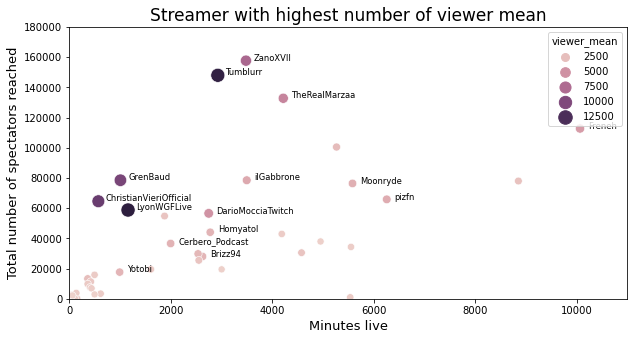

In [23]:
data = streamer_dataset.head(40)

plt.figure(figsize=(10,5))

p1=sns.scatterplot(data=data,
                x="minutes_live",
                y="spect_tot",
                hue="viewer_mean",
                size = "viewer_mean",
                sizes=(50, 200)
               )

p1.set_xlim(0, 11000)
p1.set_ylim(0, 180000)


for i in range(0,len(data.head(15))):
     p1.text(streamer_dataset.minutes_live[i]+150,
             streamer_dataset.spect_tot[i],
             streamer_dataset.streamer[i],
             horizontalalignment='left',
             size='small',
             color='black',
             #weight='semibold'
            )
        
plt.title("Streamer with highest number of viewer mean", size = 17)
plt.ylabel("Total number of spectators reached", size = 13)
plt.xlabel("Minutes live", size = 13)

plt.savefig('../DataVisualization/Main_streamers.jpg', dpi = 200)

### Export streamer dataset

In [24]:
#streamer_dataset.to_csv('Streamer_dataset.csv')

## Games dataset

In [25]:
games_list = list(set(streamer_grouped_cut.game_name.sum()))
games_list.remove('')
games_dataset = pd.DataFrame({'game_name': games_list})
games_dataset.index.name = 'ID_game'
games_dataset

,game_name
ID_game,
0,Tekken 5
1,Haunt Chaser
2,Ultimate Chicken Horse
3,Farming Simulator 22
4,ALTF4
...,...
1139,Drawize
1140,Pokémon Community Game
1141,Heave Ho


### Export games dataset

In [26]:
#games_dataset.to_csv('Games_dataset.csv')

## Streamer-Games dataset

In [27]:
streamer_games_grouped = streamer_repeated.groupby(['streamer', 'game_name'], as_index = False).agg(minutes = ('viewer_count', 'count'))
streamer_games_grouped['minutes'] = streamer_games_grouped['minutes'] * interval * freq
streamer_games_grouped

,streamer,game_name,minutes
0,0000clubtv,Music,15
1,000Skillz,Just Chatting,180
2,000dani0,Minecraft,390
3,000murasaki000,Fortnite,60
4,000smoke,League of Legends,285
...,...,...,...
82905,ばかやろう,Destiny 2,120
82906,リュウザ,Overprime,210
82907,打個遊戲,Just Chatting,300
82908,늦덕위즈원,SUPERSTAR IZ*ONE,225


In [28]:
streamer_games_grouped = pd.merge(streamer_games_grouped, streamer_dataset['streamer'].reset_index(), on = 'streamer', how = 'right')
streamer_games_grouped = pd.merge(streamer_games_grouped, games_dataset['game_name'].reset_index(), on = 'game_name', how = 'inner')
streamer_games_grouped

,streamer,game_name,minutes,ID_streamer,ID_game
0,LyonWGFLive,Among Us,15,0,367
1,gskianto,Among Us,165,80,367
2,KeNoiaaa,Among Us,45,335,367
3,Predax,Among Us,120,421,367
4,Queen_Giorgia,Among Us,480,471,367
...,...,...,...,...,...
8019,Orkprof,Anno 1404: History Edition,165,2963,554
8020,Orkprof,Backpack Hero,45,2963,141
8021,Orkprof,Forewarned,225,2963,587
8022,spizzo83,Thief Gold,255,2969,453


In [29]:
streamer_games_grouped.set_index(['ID_streamer', 'ID_game'], inplace = True)
streamer_games_grouped = streamer_games_grouped[streamer_games_grouped['minutes'] >= interval* freq * min_game_time]
streamer_games_grouped

streamer  \
ID_streamer ID_game                  
80          367           gskianto   
335         367           KeNoiaaa   
421         367             Predax   
471         367      Queen_Giorgia   
517         367         morichelss   
...                            ...   
2963        554            Orkprof   
            141            Orkprof   
            587            Orkprof   
2969        453           spizzo83   
2970        377      mtl_italy_vsc   

                                                             game_name  \
ID_streamer ID_game                                                      
80          367                                               Among Us   
335         367                                               Among Us   
421         367                                               Among Us   
471         367                                               Among Us   
517         367                                               Among Us   
...                                                                ...   
2963        554                             Anno 1404: History Edition   
            141                                          Backpack Hero   
            587                                             Forewarned   
2969        453                                             Thief Gold   
2970        377      Dragon Quest XI S: Echoes of an Elusive Age - ...   

                     minutes  
ID_streamer ID_game           
80          367          165  
335         367           45  
421         367          120  
471         367          480  
517         367           30  
...                      ...  
2963        554          165  
            141           45  
            587          225  
2969        453          255  
2970        377           75  

[7709 rows x 3 columns]

### Export streamer-games datasets

In [30]:
#streamer_games_grouped['minutes'].to_csv('Streamer-Games_dataset.csv')

## Streamer-Streamer dataset

In [31]:
spect_dict = streamer_grouped_cut[['spect_list']].to_dict()['spect_list']
len(spect_dict.keys())

500

In [32]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('Progress')

viewerOverlapDict = {}
completedStreamers = set() #Save which streamers have been processed to avoid repeating

for count, key in enumerate(spect_dict):
    tempList = {}
    totalLength = len(spect_dict.keys())
    logger.info(str(count+1) + "/" + str(totalLength)) #Print progress so I can keep track

    for comparisonKey in spect_dict: #Loop through every key again for each key in the dictionary
        if(comparisonKey != key and comparisonKey not in completedStreamers): #If its not a self comparison and the comparison hasn't already been completed
            overlapSize = len(spect_dict[key] & spect_dict[comparisonKey]) #Find the overlap size of the two streamers using set intersection
            if len(spect_dict[key]) < len(spect_dict[comparisonKey]):
                temp = round(overlapSize/len(spect_dict[key])*100, 1)
                if temp >= min_overlap_percentage:
                    tempList[comparisonKey] = temp
            else:
                temp = round(overlapSize/len(spect_dict[comparisonKey])*100, 1)
                if temp >= min_overlap_percentage:
                    tempList[comparisonKey] = temp
    viewerOverlapDict[key] = tempList #Add this comparison dictionary to the larger dictionary for that streamer
    completedStreamers.add(key) #Add the streamer to completed as no comparisons using this streamer need to be done anymore

INFO:Progress:1/500
INFO:Progress:2/500
INFO:Progress:3/500
INFO:Progress:4/500
INFO:Progress:5/500
INFO:Progress:6/500
INFO:Progress:7/500
INFO:Progress:8/500
INFO:Progress:9/500
INFO:Progress:10/500
INFO:Progress:11/500
INFO:Progress:12/500
INFO:Progress:13/500
INFO:Progress:14/500
INFO:Progress:15/500
INFO:Progress:16/500
INFO:Progress:17/500
INFO:Progress:18/500
INFO:Progress:19/500
INFO:Progress:20/500
INFO:Progress:21/500
INFO:Progress:22/500
INFO:Progress:23/500
INFO:Progress:24/500
INFO:Progress:25/500
INFO:Progress:26/500
INFO:Progress:27/500
INFO:Progress:28/500
INFO:Progress:29/500
INFO:Progress:30/500
INFO:Progress:31/500
INFO:Progress:32/500
INFO:Progress:33/500
INFO:Progress:34/500
INFO:Progress:35/500
INFO:Progress:36/500
INFO:Progress:37/500
INFO:Progress:38/500
INFO:Progress:39/500
INFO:Progress:40/500
INFO:Progress:41/500
INFO:Progress:42/500
INFO:Progress:43/500
INFO:Progress:44/500
INFO:Progress:45/500
INFO:Progress:46/500
INFO:Progress:47/500
INFO:Progress:48/500
I

INFO:Progress:379/500
INFO:Progress:380/500
INFO:Progress:381/500
INFO:Progress:382/500
INFO:Progress:383/500
INFO:Progress:384/500
INFO:Progress:385/500
INFO:Progress:386/500
INFO:Progress:387/500
INFO:Progress:388/500
INFO:Progress:389/500
INFO:Progress:390/500
INFO:Progress:391/500
INFO:Progress:392/500
INFO:Progress:393/500
INFO:Progress:394/500
INFO:Progress:395/500
INFO:Progress:396/500
INFO:Progress:397/500
INFO:Progress:398/500
INFO:Progress:399/500
INFO:Progress:400/500
INFO:Progress:401/500
INFO:Progress:402/500
INFO:Progress:403/500
INFO:Progress:404/500
INFO:Progress:405/500
INFO:Progress:406/500
INFO:Progress:407/500
INFO:Progress:408/500
INFO:Progress:409/500
INFO:Progress:410/500
INFO:Progress:411/500
INFO:Progress:412/500
INFO:Progress:413/500
INFO:Progress:414/500
INFO:Progress:415/500
INFO:Progress:416/500
INFO:Progress:417/500
INFO:Progress:418/500
INFO:Progress:419/500
INFO:Progress:420/500
INFO:Progress:421/500
INFO:Progress:422/500
INFO:Progress:423/500
INFO:Progr

In [34]:
streamer_streamer_dataset = pd.concat({k: pd.DataFrame.from_dict(v, 'index') for k, v in viewerOverlapDict.items()}, axis=0)
streamer_streamer_dataset.tail()

0
470 484  10.9
475 487  10.5
482 485  16.3
    499  66.9
485 499  82.6

In [35]:
streamer_streamer_dataset.index.names = ['ID_streamer_i', 'ID_streamer_j']
streamer_streamer_dataset.columns = ['overlap_percentage']
streamer_streamer_dataset

overlap_percentage
ID_streamer_i ID_streamer_j                    
0             95                           15.0
              129                          13.1
              141                          18.1
              176                          10.2
              182                          14.0
...                                         ...
470           484                          10.9
475           487                          10.5
482           485                          16.3
              499                          66.9
485           499                          82.6

[7202 rows x 1 columns]

In [36]:
x = []
y = []

for i in range(int(min_overlap_percentage),101,1):
    x.append(i)
    y.append(len(streamer_streamer_dataset[streamer_streamer_dataset['overlap_percentage']>i]))

C:\Users\gianl\AppData\Local\Temp/ipykernel_15236/2578546545.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


[Text(0, 0.0, '0'),
 Text(0, 200000.0, '200000'),
 Text(0, 400000.0, '400000'),
 Text(0, 600000.0, '600000'),
 Text(0, 800000.0, '800000'),
 Text(0, 1000000.0, '1000000'),
 Text(0, 1200000.0, '1200000')]

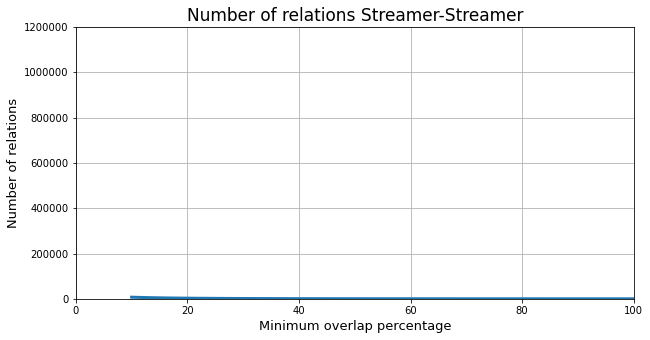

In [37]:
plt.figure(figsize=(10,5))
plt.plot(x,y, lw = 3)
plt.grid(True)

plt.title("Number of relations Streamer-Streamer", size = 17)
plt.ylabel("Number of relations", size = 13)
plt.xlabel("Minimum overlap percentage", size = 13)

plt.axis([0, 100, 0, 1200000])

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

#plt.savefig('../DataVisualization/Number_of_relations.jpg', dpi = 200)

### Export streamer-streamer dataset

In [39]:
#streamer_streamer_dataset.to_csv('Streamer-Streamer_dataset.csv')

## Short datasets for Gephi

In [42]:
streamer_grouped_cut_short = streamer_grouped_cut.head(500)

### Streamer dataset

In [67]:
streamer_dataset_short = streamer_grouped_cut_short.copy()
streamer_dataset_short = streamer_dataset_short[['streamer', 'viewer_mean']]
streamer_dataset_short['viewer_mean'] = streamer_dataset_short['viewer_mean'].apply(int)
streamer_dataset_short.columns = ['Label', 'viewer_mean']
streamer_dataset_short.index.names = ['Id']
streamer_dataset_short

,Label,viewer_mean
Id,,
0,LyonWGFLive,14011
1,Tumblurr,13683
2,ChristianVieriOfficial,11014
3,GrenBaud,10285
4,ZanoXVII,7681
...,...,...
495,thanosgamer_75,110
496,lespippo,110
497,marcofiero,109


In [68]:
#streamer_dataset_short.to_csv('../DataVisualization/Streamer_dataset_short.csv')

### Streamer-Streamer dataset

In [48]:
spect_dict_short = streamer_grouped_cut_short[['spect_list']].to_dict()['spect_list'] #short version


viewerOverlapDict_short = {}
completedStreamers = set() #Save which streamers have been processed to avoid repeating

for count, key in enumerate(spect_dict_short):
    tempList = {}
    totalLength = len(spect_dict_short.keys())
    logger.info(str(count+1) + "/" + str(totalLength)) #Print progress so I can keep track

    for comparisonKey in spect_dict_short: #Loop through every key again for each key in the dictionary
        if(comparisonKey != key and comparisonKey not in completedStreamers): #If its not a self comparison and the comparison hasn't already been completed
            overlapSize = len(spect_dict_short[key] & spect_dict_short[comparisonKey]) #Find the overlap size of the two streamers using set intersection
            if len(spect_dict_short[key]) < len(spect_dict_short[comparisonKey]):
                temp = round(overlapSize/len(spect_dict_short[key])*100, 1)
                if temp >= min_overlap_percentage:
                    tempList[comparisonKey] = temp
            else:
                temp = round(overlapSize/len(spect_dict_short[comparisonKey])*100, 1)
                if temp >= min_overlap_percentage:
                    tempList[comparisonKey] = temp
    viewerOverlapDict_short[key] = tempList #Add this comparison dictionary to the larger dictionary for that streamer
    completedStreamers.add(key) #Add the streamer to completed as no comparisons using this streamer need to be done anymore

INFO:Progress:1/500
INFO:Progress:2/500
INFO:Progress:3/500
INFO:Progress:4/500
INFO:Progress:5/500
INFO:Progress:6/500
INFO:Progress:7/500
INFO:Progress:8/500
INFO:Progress:9/500
INFO:Progress:10/500
INFO:Progress:11/500
INFO:Progress:12/500
INFO:Progress:13/500
INFO:Progress:14/500
INFO:Progress:15/500
INFO:Progress:16/500
INFO:Progress:17/500
INFO:Progress:18/500
INFO:Progress:19/500
INFO:Progress:20/500
INFO:Progress:21/500
INFO:Progress:22/500
INFO:Progress:23/500
INFO:Progress:24/500
INFO:Progress:25/500
INFO:Progress:26/500
INFO:Progress:27/500
INFO:Progress:28/500
INFO:Progress:29/500
INFO:Progress:30/500
INFO:Progress:31/500
INFO:Progress:32/500
INFO:Progress:33/500
INFO:Progress:34/500
INFO:Progress:35/500
INFO:Progress:36/500
INFO:Progress:37/500
INFO:Progress:38/500
INFO:Progress:39/500
INFO:Progress:40/500
INFO:Progress:41/500
INFO:Progress:42/500
INFO:Progress:43/500
INFO:Progress:44/500
INFO:Progress:45/500
INFO:Progress:46/500
INFO:Progress:47/500
INFO:Progress:48/500
I

INFO:Progress:379/500
INFO:Progress:380/500
INFO:Progress:381/500
INFO:Progress:382/500
INFO:Progress:383/500
INFO:Progress:384/500
INFO:Progress:385/500
INFO:Progress:386/500
INFO:Progress:387/500
INFO:Progress:388/500
INFO:Progress:389/500
INFO:Progress:390/500
INFO:Progress:391/500
INFO:Progress:392/500
INFO:Progress:393/500
INFO:Progress:394/500
INFO:Progress:395/500
INFO:Progress:396/500
INFO:Progress:397/500
INFO:Progress:398/500
INFO:Progress:399/500
INFO:Progress:400/500
INFO:Progress:401/500
INFO:Progress:402/500
INFO:Progress:403/500
INFO:Progress:404/500
INFO:Progress:405/500
INFO:Progress:406/500
INFO:Progress:407/500
INFO:Progress:408/500
INFO:Progress:409/500
INFO:Progress:410/500
INFO:Progress:411/500
INFO:Progress:412/500
INFO:Progress:413/500
INFO:Progress:414/500
INFO:Progress:415/500
INFO:Progress:416/500
INFO:Progress:417/500
INFO:Progress:418/500
INFO:Progress:419/500
INFO:Progress:420/500
INFO:Progress:421/500
INFO:Progress:422/500
INFO:Progress:423/500
INFO:Progr

In [50]:
streamer_streamer_dataset_short = pd.concat({k: pd.DataFrame.from_dict(v, 'index') for k, v in viewerOverlapDict_short.items()}, axis=0)
streamer_streamer_dataset_short.head()

0
0 95   15.0
  129  13.1
  141  18.1
  176  10.2
  182  14.0

In [51]:
streamer_streamer_dataset_short.index.names = ['Source', 'Target']
streamer_streamer_dataset_short.columns = ['Weight']
streamer_streamer_dataset_short

Weight
Source Target        
0      95        15.0
       129       13.1
       141       18.1
       176       10.2
       182       14.0
...               ...
470    484       10.9
475    487       10.5
482    485       16.3
       499       66.9
485    499       82.6

[7202 rows x 1 columns]

In [52]:
#streamer_streamer_dataset_short.to_csv('../DataVisualization/Streamer-Streamer_dataset_short.csv')